# Selekcija i evaluacija modela

Selekcija (izbor) optimalnog modela i njegova evaluacija su zadaci koji prate razvoj svakog modela mašinskog učenja. Cilj ove sveske je da približi pojmove i tehnike koje se koriste u praksi. 

In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [36]:
from sklearn import model_selection
from sklearn import svm
from sklearn import metrics
from sklearn import datasets
from sklearn import preprocessing

Skup podataka nad kojim ćemo demonstrirati tehnike selekcije i evaluacije modela je Viskonsin skup podataka za klasifikaciju tumora na benigne i maligne.

In [37]:
data = datasets.load_breast_cancer()

In [38]:
X = data.data

In [39]:
y = data.target

Klasifikator sa kojim ćemo eksperimentisati će biti kernelizovani SVM klasifikator. 

Pod hiperparametrima ili metaparametrima modela podrazumevamo parametre kojima se modeli konfigurišu. Na primer, to mogu biti vrednosti regularizacionih konstanti, broj najbližih suseda $k$ za $k$-nn algoritam, parametri kernela za kernelizovane metode, i mnogi drugi.  

# Selekcija i evaluacija modela koji nemaju hiperparametre

## Skupovi za treniranje i testiranje

U slučejevima kada modeli nemaju hiperparametre koje treba podešavati ili kada ih nije potrebno podešavati (što je u praksi jako retko), možemo podeliti skup podataka na skup za treniranje i skup za testiranje. Važno je upamtiti da ova dva skupa treba da budu **disjunktna**. 

<img src='assets/train_test.png'>

Ovu podelu smo do sada vršili korišćenjem bibliotečke funkcije `train_test_split` pri čemu smo prilikom podele parametrom `test_size` (ili ekvivalentno parametrom `train_size`) naglašavali dimenzije ovih skupova. Takođe, kako je podela skupova bila nasumična, parametrom `random_state` smo uticali na proces ove podele kako bi omogućili da se eksperimenti po potrebi reprodukuju.

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=10)

Nakon podele dobijene skupove dodatno obrađujemo tako što ih standardizujemo. Srednju vrednost i standardnu devijaciju računamo na osnovu instanci koje se nalaze **isključivo u skupu za treniranje**, i onda tako dobijene vrednosti koristimo i za standardizaciju skupa za testiranje. Do sada smo ovaj zadatak ispunjavali korišćenjem bibliotečke klase `StandardScaler` i njenih metoda `fit` i `transform`.

In [41]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Model dalje treniramo nad skupom za treniranje i ocenjujemo ga (evaluiramo) na skupu za testiranje birajući neku od metrika relevantnih za zadatak klasifikacije. 

In [42]:
model = svm.SVC()
model.fit(X_train, y_train)

SVC()

In [43]:
accuracy_score = model.score(X_test, y_test)

In [44]:
accuracy_score

0.9627659574468085

## Unakrsna validacija

Podela skupa podataka na skup za treniranje i skup za testiranje je nasumična tako da možemo imati podelu koja daje optimistično dobre ili nerealno loše rezultate. Zato je praksa da se, kadgod to skupovi podataka i modeli dozvoljavaju, više puta izvrši podela polaznog skupa na skup za treniranje i testiranje tako da svaka od instanci skupa dobije priliku da se nađe i u jednom i u drugom skupu. Jedan takav postupak predstavlja višeslojna unakrsna validacija (engl. cross validation). <img src='assets/cross_validation.png'>

Unakrsna validacija podrazumeva podelu skupa svih podataka na manje grupe, takozvane slojeve (engl. folds), recimo $k$ njih, i treniranje i evaluaciju koji se ponavljaju tačno $k$ puta. U prvom krugu treniranja i evaluacije, prvi sloj se koristi za testiranje, a preostalih $k-1$ slojeva se koristi za treniranje modela. U drugom krugu treniranja i evaluacije, drugi sloj se koristi sa testiranje, a prestalih $k-1$ slojeva za treniranje. U poslednjem krugu treniranja i evaluacije, poslednji sloj se koristi za testiranje, a prvih $k-1$ slojeva za treniranje modela. 

Na slici je prikazana unakrsna validacija sa 7 slojeva. U praksi se najčešće koriste podele na 3, 5 ili 10 slojeva. Posebno, ukoliko broj slojeva odgovara broju instanci u skupu, možemo govoriti o `leave-one-out` tehnici.

Biblioteka `scikit-learn` preko klase `KFold` omogućava particionisanje skupa podataka na opisani način. Nakon što se zada broj slojeva preko parametra `n_splits` metodom `split` se za svaku iteraciju generiše niz skupova indeksa instanci koje treba da se nađu u skupu za treniranje i skupu za testiranje. 

Sledeći primer ilustruje proces za unakrsnu validaciju sa 10 slojeva.

In [45]:
kf = model_selection.KFold(n_splits=10)

In [46]:
# u niz accuracy_scores ćemo smeštati dobijenu tačnost modela u svakoj od iteracija
accuracy_scores = []

In [47]:
# za svaku iteraciju
for train_indexes, test_indexes in kf.split(X, y):
    # izdvajamo instance skupa za treniranje
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    
    # izdvajamo instance skupa za testiranje
    X_test = X[test_indexes]
    y_test = y[test_indexes]
    
    # pripremamo podatke
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    # obučavamo model na pripremljenom skupu za treniranje
    model = svm.SVC()
    model.fit(X_train_transformed, y_train)
    
    # i evaluiramo model na pripremljenom skupu za testiranje
    score = model.score(X_test_transformed, y_test)
    
    # ovako dobijenu ocenu čuvamo u nizu svih ocena
    accuracy_scores.append(score)

Pošto smo koristitli unakrsnu validaciju sa 10 slojeva, u našem nizu sa ocenama modela se nalazi 10 ocena.

In [48]:
accuracy_scores

[0.9824561403508771,
 0.9473684210526315,
 0.9473684210526315,
 1.0,
 0.9649122807017544,
 0.9824561403508771,
 1.0,
 0.9824561403508771,
 1.0,
 0.9642857142857143]

Za tačnost našeg modela, možemo proglasiti srednju vrednost dobijenih tačnosti:

In [49]:
accuracy = np.array(accuracy_scores).mean()

In [50]:
print('Tacnost modela je: ', accuracy)

Tacnost modela je:  0.9771303258145363


Treba biti **oprezan** sa uprosečavanjem dobijenih vrednosti. Na primer, koeficijent determinacije koji se koristi za ocenu regresionih modela može biti i pozitivan i negativan pa se uprosečavanjem može dobiti pogrešna ocena. Neki od načina za popravke ovakve evaluacije će biti prikazani u sledećoj svesci.

### Bibliotečka podrška unakrsnoj validaciji

Pošto je zadatak unakrsne validacije čest, biblioteka `scikit-learn` stavlja na raspolaganje funkciju `cross_val_score` koja vrši unakrsnu validaciju. Ova funkcija od parametara očekuje model koji se evaluira, ceo skup podataka, funkciju za ocenu modela i broj slojeva (ili podeone indekse koji se u njima nalaze).

In [51]:
X = data.data

In [52]:
y = data.target

In [53]:
accuracy_scores = model_selection.cross_val_score(svm.SVC(), X, y, scoring='accuracy', cv=kf)

In [54]:
accuracy_scores

array([0.70175439, 0.9122807 , 0.9122807 , 0.89473684, 0.96491228,
       0.98245614, 0.94736842, 0.94736842, 0.9122807 , 0.98214286])

In [55]:
accuracy_scores.mean()

0.9157581453634085

Možemo primetiti da su vrednosti koje dobijamo nešto drugačije (niže) od vrednosti koje smo dobili prilikom prethodne implementacije. Ovo ponašanje dolazi kao posledica treniranja i testiranja modela na odgovarajućim podelama skupova koje nisu standardizovane. Njega možemo popraviti uvođenjem takozvanih `cevovoda` (engl. pipeline) koji definišu niz koraka koji treba sprovesti. Podrška za rad sa cevovodima dolazi kroz `pipeline` paket `scikit-learn` biblioteke.

In [56]:
from sklearn import pipeline

Mi ćemo definisati cevovod kojim naglašavamo da se prilikom podele prvo primenjuje standardizacija, a zatim i obučavanje modela. Tako ćemo dobiti unakrsnu validaciju ekvivalentnu implementiranoj.

In [57]:
svc_pipeline =  pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC())

In [58]:
accuracy_scores_with_pipeline = model_selection.cross_val_score(svc_pipeline, X, y, scoring='accuracy', cv=kf)

In [59]:
accuracy_scores_with_pipeline

array([0.98245614, 0.94736842, 0.94736842, 1.        , 0.96491228,
       0.98245614, 1.        , 0.98245614, 1.        , 0.96428571])

In [60]:
accuracy_scores_with_pipeline.mean()

0.9771303258145363

Unakrsna validacija sa zadatim brojem slojeva, u našem slučaju 10, se može dobiti na sledeći način:

In [61]:
accuracy_scores_with_cv = model_selection.cross_val_score(svc_pipeline, X, y, scoring='accuracy', cv=10)

In [62]:
accuracy_scores_with_cv

array([0.98245614, 0.96491228, 0.94736842, 0.98245614, 1.        ,
       1.        , 0.92982456, 1.        , 1.        , 0.94642857])

In [63]:
accuracy_scores_with_cv.mean()

0.975344611528822

Pošto je ova podela skupa nešto drugačija od naše polazne, i ocena blago odstupa.

## Finalni model

Finalni model je model koji obučavamo nad celim skupom podataka.

In [64]:
X = data.data
y = data.target

In [65]:
final_scaler = preprocessing.StandardScaler()
X = final_scaler.fit_transform(X)

In [66]:
final_model = svm.SVC().fit(X, y)

U praksi ovaj korak često nije realističan, pogotovo kada je reč o kompleksnim modelima čije treniranje dugo traje ili zahteva veliku količinu resursa. Zato je često scenario da se za finalni model uzima model koji je obučen na skupu za treniranje. 

# Selekcija i evaluacija modela sa hiperparametrima

## Skupovi za treniranje, validaciju i testiranje

Kako bi se odredile optimalne vrednosti hiperparametara modela, praksa je da se polazni skup podataka podeli na skup za treniranje, skup za validaciju i skup za testiranje. Model se trenira nad skupom za treniranje za različite vrednosti hiperparametara i ocenjuje na skupu za validaciju. Na osnovu ovako dobijenih rezultata se biraju optimalna vrednosti hiperparametara. Dalje se ovaj model evaluira na skupu za testiranje i tako dobijena ocena se smatra ocenom modela. 
<img src='assets/train_validation_test.png'>

Opisanu podelu skupa podataka možemo dobiti bibliotečkom funkcijom `train_test_split`.  

In [67]:
X = data.data
y = data.target

In [68]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

In [69]:
X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

Pošto treniramo kernelizovani SVM model, možemo odrediti optimalnu vrednost regularizacionog parametra `C` i širinu  Gausovog kernela `gamma`. 

In [70]:
Cs = np.array([10**i for i in range(-5, 5)])
gammas = np.array([10**i for i in range(-3, 3)])

Optimalne vrednosti hiperparametara modela ćemo ocenjivati na validacionom skupu. Pre toga ćemo pripremiti skupove tj. standardizovaćemo ih.

In [71]:
scaler_tv = preprocessing.StandardScaler()
scaler_tv.fit(X_train)
X_train = scaler_tv.transform(X_train)
X_validation = scaler_tv.transform(X_validation)

Promenljiva `best_score` će čuvati informaciju o najboljem ostvarenom skoru klasifikatora, dok će promenljiva `best_params` čuvati vrednosti hiperparametara za koje je ovaj skor dobijen. 

In [72]:
best_score = 0 
best_params = {'C':0, 'gamma': 0}

# za sve kombinacije C i gamma parametara
for C in Cs: 
    for gamma in gammas:
        # treniramo model na skupu za treniranje
        model = svm.SVC(C=C, gamma=gamma)
        model.fit(X_train, y_train)
        # ocenjujemo model na skupu za validaciju
        y_predicted = model.predict(X_validation)
        score = metrics.accuracy_score(y_validation, y_predicted)
        # ukoliko je dobijeni skor najbolji, pamtimo njegovu vrednost i vrednosti parametara
        if score > best_score: 
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

In [73]:
best_score

0.987012987012987

In [74]:
best_params

{'C': 10.0, 'gamma': 0.01}

Za dobijene vrednosti hiperparametara obučavamo model na **uniji** skupa za treniranje i validaciju. Pre toga ćemo pripremiti skup tako što ćemo ga standardizovati. 

In [75]:
scaler_tt = preprocessing.StandardScaler()
scaler_tt.fit(X_train_validation)
X_train_validation = scaler_tt.transform(X_train_validation)

In [76]:
model = svm.SVC(C=best_params['C'], gamma=best_params['gamma'])

In [77]:
model.fit(X_train_validation, y_train_validation)

SVC(C=10.0, gamma=0.01)

Model evaluiramo na skupu za testiranje. Pre toga ćemo pripremiti skup tako što ćemo ga standardizovati koristeći informacije o srednjoj vrednosti i standardnoj devijaciji `X_train_validation` skupa nad kojem je model treniran.

In [78]:
X_test = scaler_tt.transform(X_test)

In [79]:
y_predicted = model.predict(X_test)

In [80]:
metrics.accuracy_score(y_test, y_predicted)

0.9680851063829787

### Unakrsna validacija

Podela skupa podataka na skup za treniranje, validaciju i testiranje ima iste nedostatke kao i podela opisana u slučaju neparametarskih modela. Stoga se može koristiti unakrsna validacija. 

### Unakrsna validacija za evaluaciju modela sa hiperparametrima

Ukoliko su vrednosti hiperparameta poznate, unakrsna validacija se primenjuje na način koji smo do sada upoznali.

In [81]:
X = data.data
y = data.target

In [82]:
model = svm.SVC(C=best_params['C'], gamma=best_params['gamma'])

In [83]:
scaler = preprocessing.StandardScaler()

In [84]:
svc_pipeline =  pipeline.make_pipeline(scaler, model)

In [85]:
scores = model_selection.cross_val_score(svc_pipeline, X, y, scoring='accuracy', cv = 10)

In [86]:
scores

array([1.        , 0.98245614, 0.96491228, 0.98245614, 0.98245614,
       0.98245614, 0.92982456, 1.        , 1.        , 0.96428571])

In [87]:
scores.mean()

0.9788847117794484

### Određivanje vrednosti hiperparametra unakrsnom validacijom

Unakrsna validacija se može koristiti i za određivanje vrednosti hiperparametara modela. Ovde treba obratiti pažnju da se prosleđuje unija trening i validacinog skupa metodi `cross_val_score`.

In [88]:
Cs = np.array([10**i for i in range(-5, 5)])
gammas = np.array([10**i for i in range(-3, 3)])

In [89]:
best_score = 0 
best_params = {'C':0, 'gamma': 0}

scaler = preprocessing.StandardScaler()

# za sve kombinacije C i gamma parametara
for C in Cs: 
    for gamma in gammas:
        # vrsimo ocenu modela na uniji trening i validacionog skupa koriscenjem 10-struke unakrsne validacije
        model = svm.SVC(C=C, gamma=gamma)
        svc_pipeline = pipeline.make_pipeline(scaler, model)
        scores = model_selection.cross_val_score(svc_pipeline, X_train_validation, y_train_validation, scoring='accuracy', cv=10)
        
        # za skor (ocenu) modela uzimamo prosek dobijenih vrednosti
        score = scores.mean()
        
        # ukoliko je dobijeni skor najbolji, pamtimo njegovu vrednost i vrednost parametara
        if score > best_score: 
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

In [90]:
best_score

0.97638326585695

In [91]:
best_params

{'C': 10.0, 'gamma': 0.01}

Biblioteka `scikit-learn` nudi podršku za korišćenje unakrsne validacije za određivanje vrednosti hiperparametara pomoću klase `GridSearchCV`(CV na kraju naziva metode je akronim za `cross-validation`). Konstruktor očekuje model za koji treba odrediti vrednosti hiperparametara, rečnik svih hiperparametara koje treba razmotriti, funkciju za ocenu modela, broj slojeva i, opciono, parametar kojim se naglašava da se svi dobijeni rezultati mogu sačuvati u formi izveštaja. Potom se metodom `fit` vrši pretraga prostora parametara na gore opisani način, takođe nad unijom skupa za treniranje i validaciju.

In [92]:
grid_model = pipeline.Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('svm', svm.SVC())])
params = {
    'svm__C': [10**i for i in range(-5, 5)], 
    'svm__gamma': [10**i for i in range(-3, 3)]
}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=10, return_train_score=True)

In [93]:
grid.fit(X_train_validation, y_train_validation)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                    1000, 10000],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy')

Svojstva `best_score_` i `best_params_` omogućavaju očitavanje najboljeg rezultata i njemu pridruženih parametara.

In [94]:
grid.best_score_

0.97638326585695

In [95]:
grid.best_params_

{'svm__C': 10, 'svm__gamma': 0.01}

Informacije o svakom koraku unakrsne validacije za svaku kombinaciju vrednosti hiperparametara su dostupne kroz izveštaj `cv_results_`. Broj različitih vrednosti parametra `C` je 10, a parametra `gamma` 6. 

In [96]:
cv_results = pd.DataFrame(grid.cv_results_)

In [97]:
cv_results.shape

(60, 32)

Vrednosti koje se čuvaju na nivou izveštaja su:

In [98]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svm__C', 'param_svm__gamma', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

Vrednost `mean_test_score` izveštaja sadrži prosečnu vrednost ocene na korišćenim test skupovima ili preciznije, u našem kontekstu određivanja vrednosti hiperparametara, validacionim skupovima. 

In [99]:
cv_results['mean_test_score']

0     0.627328
1     0.627328
2     0.627328
3     0.627328
4     0.627328
5     0.627328
6     0.627328
7     0.627328
8     0.627328
9     0.627328
10    0.627328
11    0.627328
12    0.627328
13    0.627328
14    0.627328
15    0.627328
16    0.627328
17    0.627328
18    0.627328
19    0.627328
20    0.627328
21    0.627328
22    0.627328
23    0.627328
24    0.716734
25    0.950135
26    0.918623
27    0.627328
28    0.627328
29    0.627328
30    0.952767
31    0.965924
32    0.944872
33    0.627328
34    0.627328
35    0.627328
36    0.960661
37    0.976383
38    0.929150
39    0.629960
40    0.627328
41    0.627328
42    0.976383
43    0.965924
44    0.926518
45    0.629960
46    0.627328
47    0.627328
48    0.968556
49    0.952767
50    0.926518
51    0.629960
52    0.627328
53    0.627328
54    0.955398
55    0.952767
56    0.926518
57    0.629960
58    0.627328
59    0.627328
Name: mean_test_score, dtype: float64

Informacije iz izveštaja se mogu koristiti i za uvid u opsege vrednosti iz kojih su hiperparametri birani. To se obično radi vizuelizacijom u vidu toplotne mape. Ukoliko su opsezi vrednosti dobro birani, optimalne vrednosti su skoncentrisane po sredini.

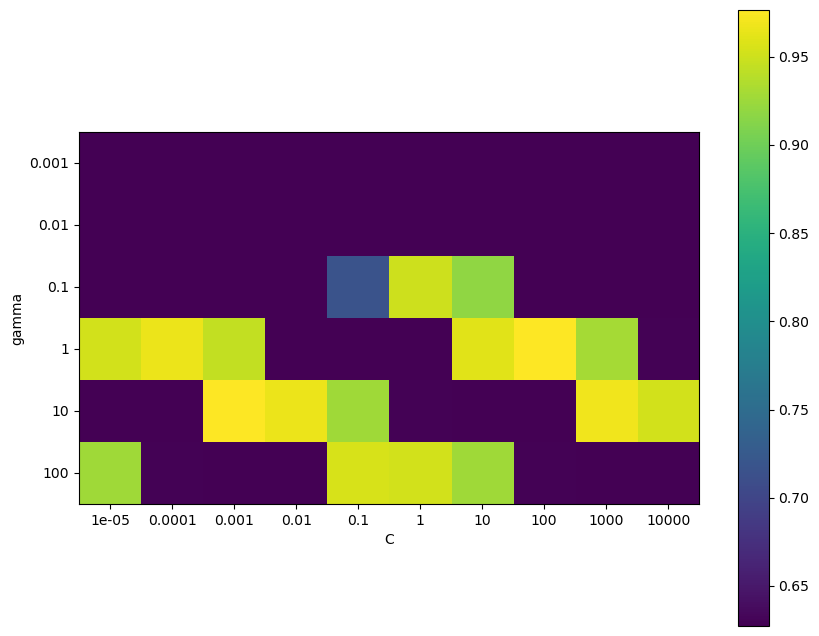

In [100]:
cv_test_score = cv_results['mean_test_score'].values.reshape(6, 10)

Cs = [10**i for i in range(-5, 5)]
gammas =[10**i for i in range(-3, 3)]

plt.figure(figsize=(10, 8))

plt.ylabel('gamma')
plt.yticks(np.arange(0, len(gammas)), gammas)

plt.xlabel('C')
plt.xticks(np.arange(0, len(Cs)), Cs)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

U našem slučaju bi imalo smisla ispitati ponašanje modela i za vrednosti parametra `gamma` koje su nešto veće od 100.

## Ugnježđena unakrsna validacija

Korišćenje unakrsne validacije za određivanje optimalne vrednosti hiperparametara i dalje ostavlja otvorenim podelu skupa podataka na skup za treniranje i validaciju sa jedne strane, i skup za testiranje sa druge strane. I za drugo se može koristiti, baš kao i u slučaju neparametarskih modela, unakrsna validacija. Time dobijamo ugnježđenu unakrsnu validaciju (engl. nested cross-validation). <img src='assets/nested_cross_validation.png'>

Ona se na nivou biblioteke jednostavno implementira kombinacijom `GridSearchCV` i `cross_val_score` funkcija.

In [101]:
grid_model = pipeline.Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('svm', svm.SVC())])

In [102]:
params = {
    'svm__C': [10**i for i in range(-5, 5)], 
    'svm__gamma': [10**i for i in range(-3, 3)]
}

Napomena: Zbog broja kombinacija, izvršavanje ove naredbe može duže da traje.

In [103]:
scores = model_selection.cross_val_score(model_selection.GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=10),\
                                         X, y, scoring='accuracy', cv=10)

In [104]:
scores

array([1.        , 0.98245614, 0.96491228, 0.98245614, 0.94736842,
       0.96491228, 0.92982456, 1.        , 1.        , 0.96428571])

In [105]:
print("Minimalna tacnost: %f\nMaksimalna tacnost: %f\nsrednja vrednost: %f" % (np.min(scores), np.max(scores), np.mean(scores)))

Minimalna tacnost: 0.929825
Maksimalna tacnost: 1.000000
srednja vrednost: 0.973622


Dobijena prosečna tačnost se može prijaviti kao tačnost našeg modela. 

<div class='alert alert-info'>
    <b> Domaći zadatak: </b> reimplementirati metodu ugnježđene unakrsne validacije. 
</div>

## Finalni model

Finalni model dobijamo kada za vrednosti hiperparametara uzmemo optimalne vrednosti dobijene ili korišćenjem validacionog skupa ili korišćenjem unakrsne validacije i istreniramo ga na celom skupu podataka.

In [106]:
X = data.data
y = data.target

In [107]:
final_scaler = preprocessing.StandardScaler()
X = final_scaler.fit_transform(X)

In [108]:
final_model = svm.SVC(C=best_params['C'], gamma=best_params['gamma'])

In [109]:
final_model.fit(X, y)

SVC(C=10.0, gamma=0.01)

Baš kao i kod neparametarskih modela u praksi se finalni parametarski modeli koji zahtevaju velike resurse ili čije treniranje dugo traje ne treniraju na celom skupu, već se za finalni model prograšava model dobijen na skupu za treniranje ili skupu za treniranje i validaciju. 